# Preprocessing of IBG lab wireless data

In [3]:
import time
import pickle
import os

import numpy as np
print(f"numpy version {np.__version__}")
import matplotlib
import matplotlib.pyplot as plt
print(f"matplotlib version {matplotlib.__version__}")
import pandas as pd
print(f"pandas version {pd.__version__}")
import preprocess as pp
print(f"preprocess version {pp.__version__}")
import scipy.signal as sig
from scipy import __version__ as ver
print(f"scipy version {ver}")

# Enable reloading of packages upon changes
%reload_ext autoreload
%autoreload 2

# Enable resizing of Jupyter notebook based on the browser width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

numpy version 1.16.4
matplotlib version 3.3.1
pandas version 0.24.2
preprocess version 0.0.5
scipy version 1.5.2


In [ ]:
# setting up a logger for the module, 
# by defaut, it would print all warning messages to stdout 
# while also recording debug
import logging

formatter = logging.Formatter('%(asctime)s %(funcName)5s %(levelname)s: %(message)s')
logFile = 'preprocess log'
# logging.basicConfig(format=form)
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('preprocessing.log')
fh.setLevel(logging.DEBUG)
fh.setFormatter(formatter)
logger.addHandler(fh)

sh = logging.StreamHandler()
sh.setLevel(logging.WARNING)
sh.setFormatter(formatter)
logger.addHandler(sh)

In [4]:
#dataDir = '/home/orel/Data/K6/2020-03-27/WL/'
dataDir = "D:\\Users\\Matan\\Downloads\\preprocess files test\\"
elecList = list(range(2,6))+list(range(7,22))+list(range(23,33))
fileList = list(range(0,265))
rangeStr = "-F{0}T{1}".format(fileList[0], fileList[-1])

# The original data is stored in DT2 files - 32ch multiplexed data sampled at 32KHZ

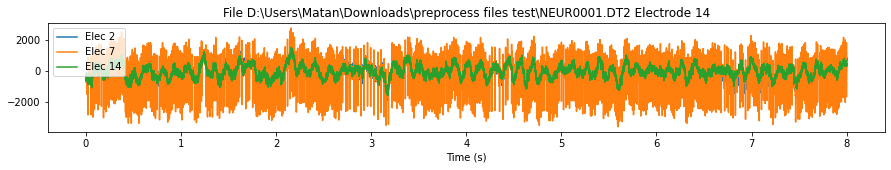

In [5]:
fig, axes = pp.plotWireless(dataDir + 'NEUR0001.DT2', [0, 8], [2,7,14])
fig.set_size_inches((15,2))

# The first tranformation is to continuous binary files separated by channel number

In [ ]:
# elecList = list(range(2,15))+[17,18]+list(range(20,32))
# fileList = list(range(0,214))

timeBegin = time.time()
lData = pp.wirelessToBin(dataDir,dataDir + 'binNew/',fileList, elecList, verbose=False)
timeEnd = time.time()
print(f"Converted {len(elecList)} electrodes {lData:,d} samples in {timeEnd-timeBegin:.2f} seconds")

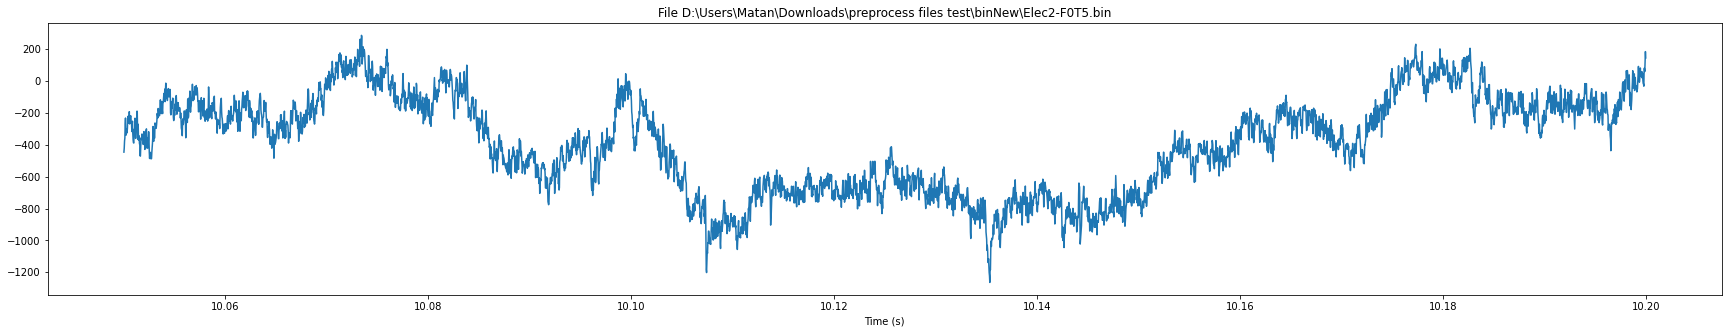

In [9]:
fig, axes = pp.plotBin(os.path.join("D:\\Users\\Matan\\Downloads\\preprocess files test\\binNew", 'Elec2-F0T5.bin'), [10.05,10.2])
fig.set_size_inches((30,5))

# Binary data can be downsampled to 1 KHz and band pass and (opt) notch filtered

In [ ]:
timeBegin = time.time()
pp.binToLFP(dataDir+'binNew/', dataDir+'binLFPN/', '{0}Elec{1}' + rangeStr + '.bin', elecList
                    , freq=[2, 300], notch=True, verbose=True)
timeEnd = time.time()
print(f"Downsampled {len(elecList)} electrodes in {timeEnd-timeBegin:.2f} seconds")

In [ ]:
fig, axes = pp.plotBin(dataDir + 'binLFPN/Elec3' + rangeStr+ '.bin', [0, 5], samplingRate=1000)
fig.set_size_inches((10,5))

# Remove median from the electrodes

In [ ]:
# Remove median from SNr electrodes:
elecList = list(range(2,6))+list(range(7,17))
timeBegin = time.time()
pp.remMedian(os.path.join(dataDir, 'binBand'), os.path.join(dataDir, 'binMed') , elecList, rangeStr, batchSize=1000000, verbose=True)
timeEnd = time.time()
print(f"Remove median for {len(elecList)} in {timeEnd-timeBegin} seconds ")

In [ ]:
# Remove median from Str electrodes:
elecList = list(list(range(17,22))+list(range(23,32)))
timeBegin = time.time()
pp.remMedian(os.path.join(dataDir, 'binBand'), os.path.join(dataDir, 'binMed'), elecList, rangeStr, batchSize=1000000, verbose=True)
timeEnd = time.time()
print(f"Remove median for {len(elecList)} in {timeEnd-timeBegin} seconds ")

In [ ]:
elc = 10
fig, axes = pp.plotBin(os.path.join(dataDir, 'binBand', 'Elec' + str(elc) + rangeStr + '.bin'), [0, 0.5])
fig.set_size_inches((10,5))

# The kinematic data may be extracted from the raw files

In [ ]:
timeBegin = time.time()
df = pp.wirelessToMotion(dataDir,fileList,outDir=dataDir+'binNew/', verbose=True)
timeEnd = time.time()
print(f"Extract kinematic parameters in {timeEnd-timeBegin} seconds ")

In [ ]:
df.sample(5)

In [ ]:
print(df['acc','x'][0:10])
fid=open(dataDir + 'binNew/Motion' + rangeStr + '.pkl','rb')
dd=pickle.load(fid)
print(dd['acc','x'][0:10])

In [ ]:
bRange, eRange = 10000, 25000

plt.plot(df['gyr','x'][bRange:eRange],label='gyrX')
plt.plot(df['acc','x'][bRange:eRange],label='accX')
plt.plot(df['mag','x'][bRange:eRange]*100,label='magX')
plt.legend()
plt.show()

# May pass high pass filter to remove any remaining low frequencies from the data

In [ ]:
elecList = list(range(2,6))+list(range(7,22))+list(range(23,32))
pp.bandpass_filter(os.path.join(dataDir,'binNew'), os.path.join(dataDir,'binBand'), 'Elec{0}' + rangeStr + '.bin', elecList, freq=[300, 6000])

In [ ]:
rng = [3,5]
elc = 27

fig, axes = pp.plotBin(os.path.join(dataDir,'binMed','Elec' + str(elc) + rangeStr + '.bin'), rng)
fig.set_size_inches((10,5))

In [ ]:
fig, axes = pp.plotBin(os.path.join(dataDir, 'binBand', 'Elec' + str(elc) + rangeStr + '.bin'), rng)
fig.set_size_inches((10,5))